### Aim:
First look at the dataset

### Dataset description: 
We are given information of 1449 buildings, BUILDING_ID is a unique identifier across both the train and test datasets. 


In [6]:
# import necessary dependencies
import numpy as np
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import os, warnings, math
import gc # module for optional garbage collection
gc.enable() #Enable automatic garbage collection.
import time
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import matplotlib.patches as patches
import seaborn as sns

#sns.set(style = 'white')

In [2]:
# notebook project directories
base_dir = '/home/prayush/bj/energy_predictor'
input_dir = os.path.join(base_dir, 'input')
checkpoint_dir = os.path.join(base_dir, 'checkpoints')
plot_dir = os.path.join(base_dir, 'plots')
output_dir = os.path.join(base_dir, 'output')
os.system("mkdir -p {} {} {} {}".format(base_dir, checkpoint_dir,plot_dir, output_dir))

0

In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

# Reducing memory size of the dataframes - option 1

In [7]:
# Very useful if you are having RAM issues

In [29]:
########################### Helpers
#################################################################################
## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
# Copy from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# and https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
# Modified to support timestamp type
# Modified to add option to use float16 or not. feather format does not support float16.
def reduce_mem_usage(df, verbose=True, use_float16=False):
    """ 
iterate through all the columns of a dataframe and modify the data type
to reduce memory usage.        
    """
    # numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if is_datetime(df[col]):
            # skip datetime type
            continue
        col_type = df[col].dtypes
        
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
       
            
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [31]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
building_df = reduce_mem_usage(building_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
submit_df = reduce_mem_usage(submit_df)

Mem. usage decreased to 173.90 Mb (0.0% reduction)
Mem. usage decreased to 358.65 Mb (0.0% reduction)
Mem. usage decreased to  0.02 Mb (0.0% reduction)
Mem. usage decreased to  2.65 Mb (0.0% reduction)
Mem. usage decreased to  5.25 Mb (0.0% reduction)
Mem. usage decreased to 198.83 Mb (68.7% reduction)


# Feather format for faster loading

In [5]:
# additional possibilites - using feather format for fast loading
# canoot be using with the reduce_mem_usage function because feather works with float 32 and 64
# float 16 will cause problems


#Save data in feather format
#%%time

train_df.to_feather('train.feather')
test_df.to_feather('test.feather')
weather_train_df.to_feather('weather_train.feather')
weather_test_df.to_feather('weather_test.feather')
building_df.to_feather('building_metadata.feather')
submit_df.to_feather('sample_submission.feather')


#Read data in feather format
#You can see "+ Add data" button on top-right of notebook, press this button and add output of this kernel, then you can use above saved feather data frame for fast loading!

#Let's see how fast it is.

#%%time

train_df = pd.read_feather('train.feather')
weather_train_df = pd.read_feather('weather_train.feather')
test_df = pd.read_feather('test.feather')
weather_test_df = pd.read_feather('weather_test.feather')
building_df = pd.read_feather('building_metadata.feather')
submit_df = pd.read_feather('sample_submission.feather')



# discussion on usage 
# https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet


# checking, shapes data types of the files

## all files

In [12]:
print('Shape of train_df is ' + str(train_df.shape))
print('Shape of test._df is ' + str(test_df.shape))
print('Shape of building_df is ' + str(building_df.shape))
print('Shape of weather_train_df is ' + str(weather_train_df.shape))
print('Shape of weather_test_df is ' + str(weather_test_df.shape))

Shape of train_df is (20216100, 4)
Shape of test._df is (41697600, 4)
Shape of building_df is (1449, 6)
Shape of weather_train_df is (139773, 9)
Shape of weather_test_df is (277243, 9)


**train_df** comprises of 20216100 observations and 4 characteristics.<BR />
   1. building_id - Foreign key for the building metadata.
   2. meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
   3. timestamp - When the measurement was taken
   4. meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.
   
<BR />
Dependent variable:meter_reading depends on (independent variable) meter and time_stamp

**building_df** comprises of 1449 observations and 6 charecteristics <BR/>
   1. site_id - Foreign key for the weather files.
   2. building_id - Foreign key for training.csv
   3. primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
   4. square_feet - Gross floor area of the building
   5. year_built - Year building was opened
   6. floor_count - Number of floors of the building
   
square_feet depends on the primary_use, year_built, floor_count

**weather_train** comprises of 139773 observations and 9 charecteristics <BR />

Weather data from a meteorological station as close as possible to the site.

1. site_id
2. air_temperature - Degrees Celsius
3. cloud_coverage - Portion of the sky covered in clouds, in oktas
4. dew_temperature - Degrees Celsius
5. precip_depth_1_hr - Millimeters
6. sea_level_pressure - Millibar/hectopascals
7. wind_direction - Compass direction (0-360)
8. wind_speed - Meters per second

dependence on 2-8

It is also a good practice to know the columns and their corresponding data types,along with finding whether they contain null values or not.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [14]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [15]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 GB


In [17]:
submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB


**Summary** statistics: doesnt make sense till we classify by meter type for the train_df data 

In [18]:
train_df.describe()
# no missing data as can be seen from count

building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   2.117121e+03
std    4.269133e+02  9.309921e-01   1.532356e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07

In [19]:
building_df.describe()
# missing data in year built and floor count

site_id  building_id    square_feet   year_built  floor_count
count  1449.000000  1449.000000    1449.000000   675.000000   355.000000
mean      6.952381   724.000000   92111.776398  1967.957037     3.740845
std       5.003432   418.434583  110769.950997    31.054030     3.333683
min       0.000000     0.000000     283.000000  1900.000000     1.000000
25%       3.000000   362.000000   23012.000000  1949.000000     1.000000
50%       5.000000   724.000000   57673.000000  1970.000000     3.000000
75%      13.000000  1086.000000  115676.000000  1995.000000     5.000000
max      15.000000  1448.000000  875000.000000  2017.000000    26.000000

In [20]:
weather_train_df.describe()
# Blots of missing data here - cloud coverage, dew_temperature, precip_depth_1_hr, 
# sea_level_pressure, wind_direction, wind_speed

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  139773.000000    139718.000000    70600.000000    139660.000000   
mean        7.478977        14.418106        2.149306         7.350158   
std         4.604744        10.626595        2.599150         9.790235   
min         0.000000       -28.900000        0.000000       -35.000000   
25%         3.000000         7.200000        0.000000         0.600000   
50%         7.000000        15.000000        2.000000         8.300000   
75%        11.000000        22.200000        4.000000        14.400000   
max        15.000000        47.200000        9.000000        26.100000   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count       89484.000000       129155.000000   133505.000000  139469.000000  
mean            0.983047         1016.158038      180.526632       3.560527  
std             8.463678            7.629684      111.523629       2.335874  
min            -1.000000          968.200000        0.000000       0.000000  
25%             0.000000         1011.800000       80.000000       2.100000  
50%             0.000000         1016.400000      190.000000       3.100000  
75%             0.000000         1020.800000      280.000000       5.000000  
max           343.000000         1045.500000      360.000000      19.000000

In [21]:
train_df.head()

building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0

## train

###  building ids

In [22]:
pd.Series(train_df['building_id'], dtype = "category").describe()

count     20216100
unique        1449
top           1298
freq         35136
Name: building_id, dtype: int64

In [23]:
print("Number of unique building_id in training set {}".format(pd.Series(train_df['building_id'], dtype = "category").describe()['unique']))

Number of unique building_id in training set 1449


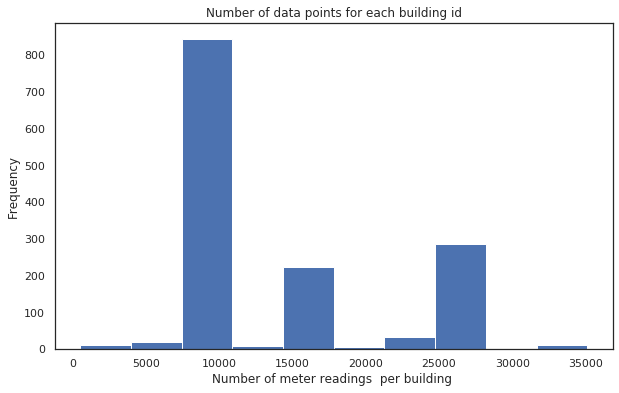

In [24]:
plt.figure(figsize = (10,6))
plt.hist(list(train_df['building_id'].value_counts()), bins = 10)
plt.title("Number of data points for each building id")
plt.xlabel("Number of meter readings  per building ")
plt.ylabel("Frequency")
plt.show()

In [52]:
train_df['building_id'].value_counts().describe()

count     1449.000000
mean     13951.759834
std       7434.564485
min        479.000000
25%       8781.000000
50%       8784.000000
75%      17568.000000
max      35136.000000
Name: building_id, dtype: float64

### Timestamps

In [25]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['timestamp'].describe()

count                20216100
unique                   8784
top       2016-12-27 22:00:00
freq                     2370
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

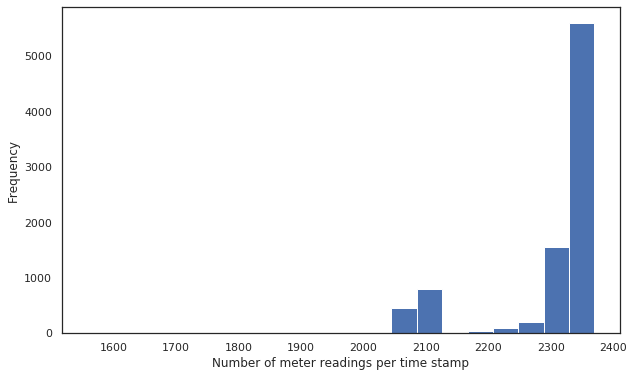

In [26]:
plt.figure(figsize = (10,6))
plt.hist(list(train_df['timestamp'].value_counts()), bins = 20)
plt.xlabel('Number of meter readings per time stamp')
plt.ylabel('Frequency')
plt.show()

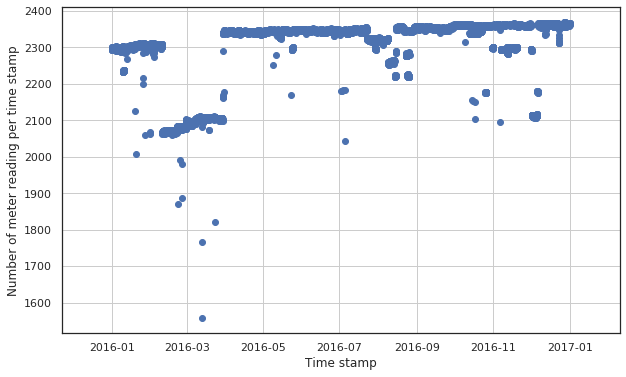

In [27]:
x = train_df['timestamp'].value_counts().index
y = train_df['timestamp'].value_counts()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('Number of meter reading per time stamp')
plt.show()

### meter reading and meter id

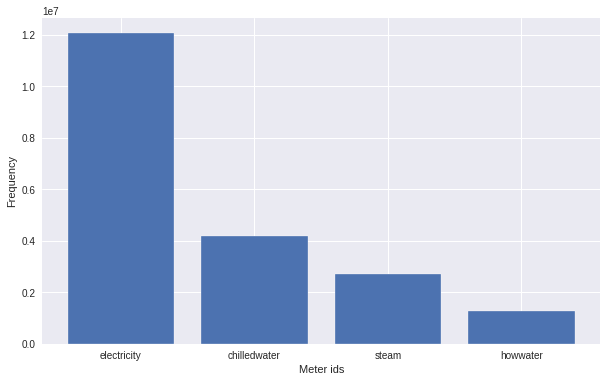

In [164]:
plt.figure(figsize = (10,6))
plt.bar(["electricity", "chilledwater", "steam", "howwater"], train_df['meter'].value_counts())
plt.xlabel('Meter ids')
plt.ylabel('Frequency')
plt.show()

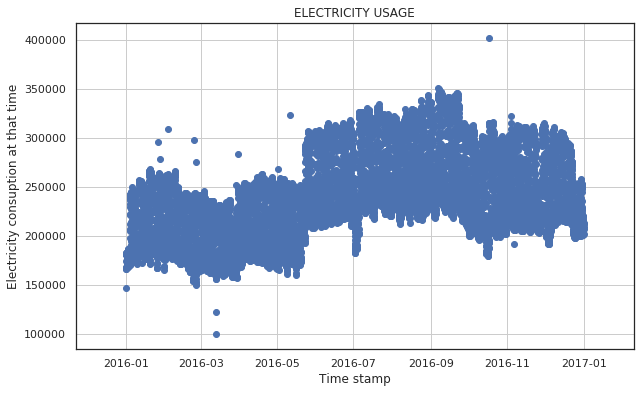

In [28]:
electricity = train_df[train_df['meter'] == 0]
x = electricity.groupby(by = ['timestamp'])['meter_reading'].sum().index
y = electricity.groupby(by = ['timestamp'])['meter_reading'].sum()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('Electricity consuption at that time')
plt.title('ELECTRICITY USAGE')
plt.show()

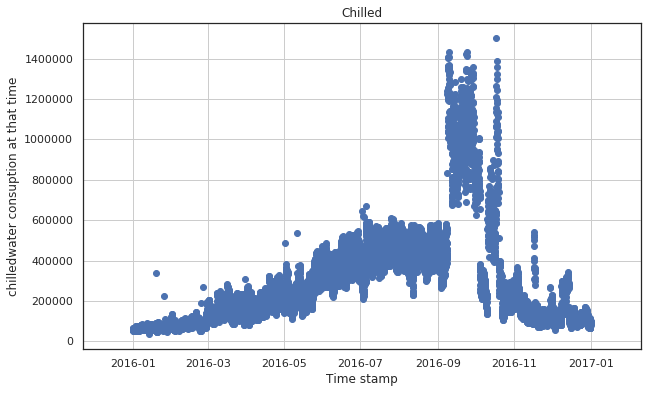

In [29]:
chilledwater = train_df[train_df['meter'] == 1]
x = chilledwater.groupby(by = ['timestamp'])['meter_reading'].sum().index
y = chilledwater.groupby(by = ['timestamp'])['meter_reading'].sum()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('chilledwater consuption at that time')
plt.title('Chilled')
plt.show()

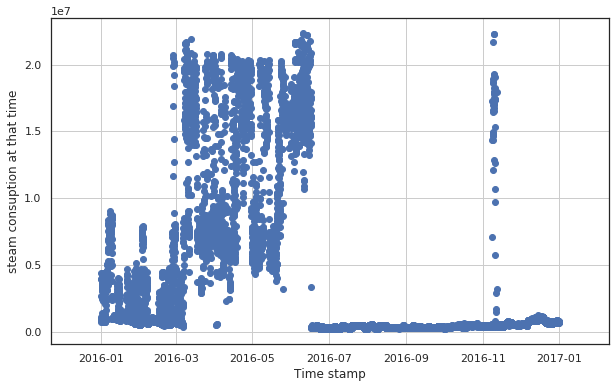

In [30]:
steam = train_df[train_df['meter'] == 2]
x = steam.groupby(by = ['timestamp'])['meter_reading'].sum().index
y = steam.groupby(by = ['timestamp'])['meter_reading'].sum()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('steam consuption at that time')
plt.show()

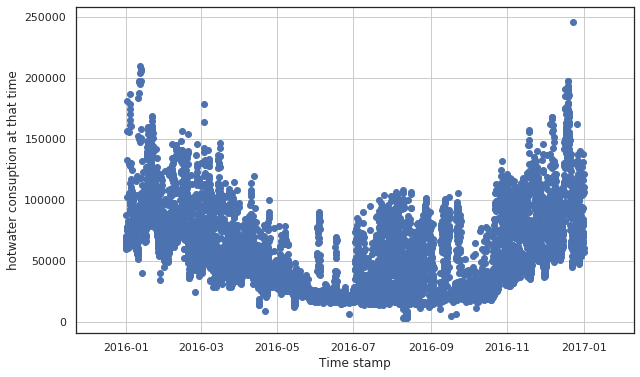

In [31]:
hotwater = train_df[train_df['meter'] == 3]
x = hotwater.groupby(by = ['timestamp'])['meter_reading'].sum().index
y = hotwater.groupby(by = ['timestamp'])['meter_reading'].sum()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('hotwater consuption at that time')
plt.show()

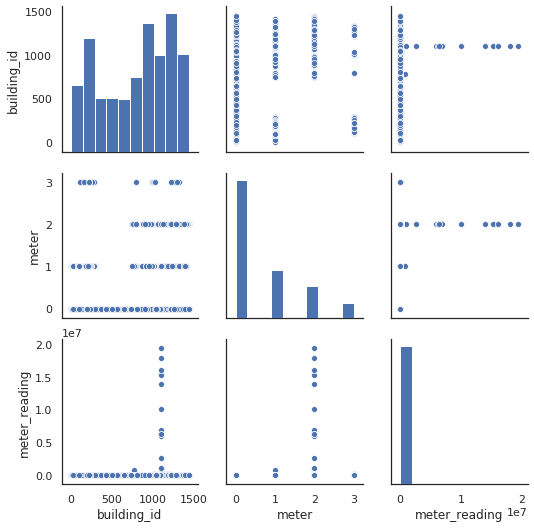

In [32]:
sns.pairplot(train_df.sample(100000, random_state = 0))

In [149]:
train_df.sample(100000, random_state = 0)

building_id  meter           timestamp  meter_reading
11990877          774      1 2016-08-07 08:00:00      36.128899
15256244          206      0 2016-10-04 14:00:00     226.270004
18401495         1269      0 2016-11-29 10:00:00      28.670799
15573710          951      0 2016-10-10 04:00:00     113.000000
6515439           656      0 2016-05-01 21:00:00      32.700001
...               ...    ...                 ...            ...
12168347         1444      0 2016-08-10 13:00:00       5.475000
16509679          426      0 2016-10-26 20:00:00      72.720001
18045088         1283      2 2016-11-23 03:00:00     879.331970
13547539          501      0 2016-09-04 08:00:00      58.950001
12069153          217      3 2016-08-08 18:00:00       0.000000

[100000 rows x 4 columns]

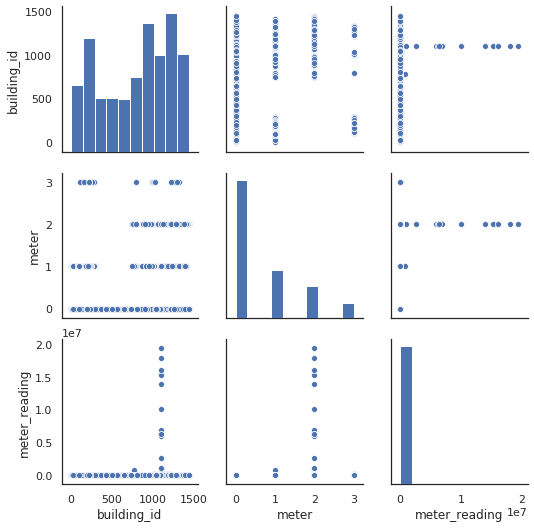

In [62]:
sns.pairplot(train_df.sample(100000, random_state = 0))

In [166]:
train_df.groupby(by = ['building_id', 'meter'])['building_id'].value_counts().describe()

count    2380.000000
mean     8494.159664
std       782.285680
min       479.000000
25%      8758.000000
50%      8781.000000
75%      8784.000000
max      8784.000000
Name: building_id, dtype: float64

In [167]:
train_df.groupby(by = ['building_id', 'meter'])['meter'].value_counts().describe()

count    2380.000000
mean     8494.159664
std       782.285680
min       479.000000
25%      8758.000000
50%      8781.000000
75%      8784.000000
max      8784.000000
Name: meter, dtype: float64

In [168]:
train_df.groupby(by = ['building_id', 'meter'])['meter_reading'].value_counts().describe()

count    8.142553e+06
mean     2.482772e+00
std      3.413647e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      8.783000e+03
Name: meter_reading, dtype: float64

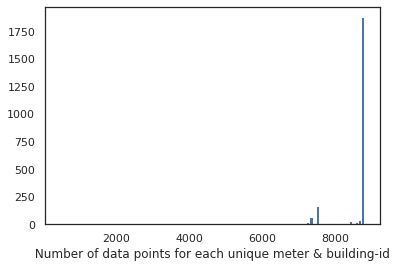

In [38]:
plt.figure(figsize = (6,4))
plt.hist(list(train_df.groupby(by = ['building_id', 'meter'])['meter'].value_counts()), bins = 100 )
plt.xlabel( ' Number of data points for each unique meter & building-id ')
plt.show()

total number of readings for meter type electricity          12060910
total number of readings for meter type electricity          11530741
total number of readings for meter type chilledwater          4182440
total number of readings for meter type chilledwater          3525936
total number of readings for meter type steam          2708713
total number of readings for meter type steam          2361753
total number of readings for meter type hotwater          1264037
total number of readings for meter type hotwater          923694


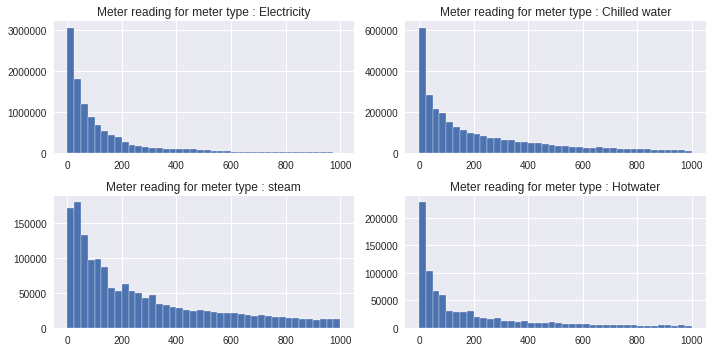

In [114]:
fig, axes = plt.subplots(2, 2, figsize = (10,5))


a =train_df['meter_reading'][train_df['meter'] == 0]
nonzero = a[a != 0]
print(f"total number of readings for meter type electricity          {len(a)}")
print(f"total number of readings for meter type electricity          {len(nonzero)}")
axes[0,0].hist(nonzero[nonzero <= 1000], bins=40)
axes[0,0].set_title('Meter reading for meter type : Electricity')

a =train_df['meter_reading'][train_df['meter'] == 1]
nonzero = a[a != 0]
print(f"total number of readings for meter type chilledwater          {len(a)}")
print(f"total number of readings for meter type chilledwater          {len(nonzero)}")
axes[0,1].hist(nonzero[nonzero <= 1000], bins=40)
axes[0,1].set_title('Meter reading for meter type : Chilled water')

a =train_df['meter_reading'][train_df['meter'] == 2]
nonzero = a[a != 0]
print(f"total number of readings for meter type steam          {len(a)}")
print(f"total number of readings for meter type steam          {len(nonzero)}")
axes[1,0].hist(nonzero[nonzero <= 1000], bins=40)
axes[1,0].set_title('Meter reading for meter type : steam')

a =train_df['meter_reading'][train_df['meter'] == 3]
nonzero = a[a != 0]
print(f"total number of readings for meter type hotwater          {len(a)}")
print(f"total number of readings for meter type hotwater          {len(nonzero)}")
axes[1,1].hist(nonzero[nonzero <= 1000], bins=40)
axes[1,1].set_title('Meter reading for meter type : Hotwater')

plt.tight_layout() # makes sure the titles and x-axes labels dont mess up
plt.show()

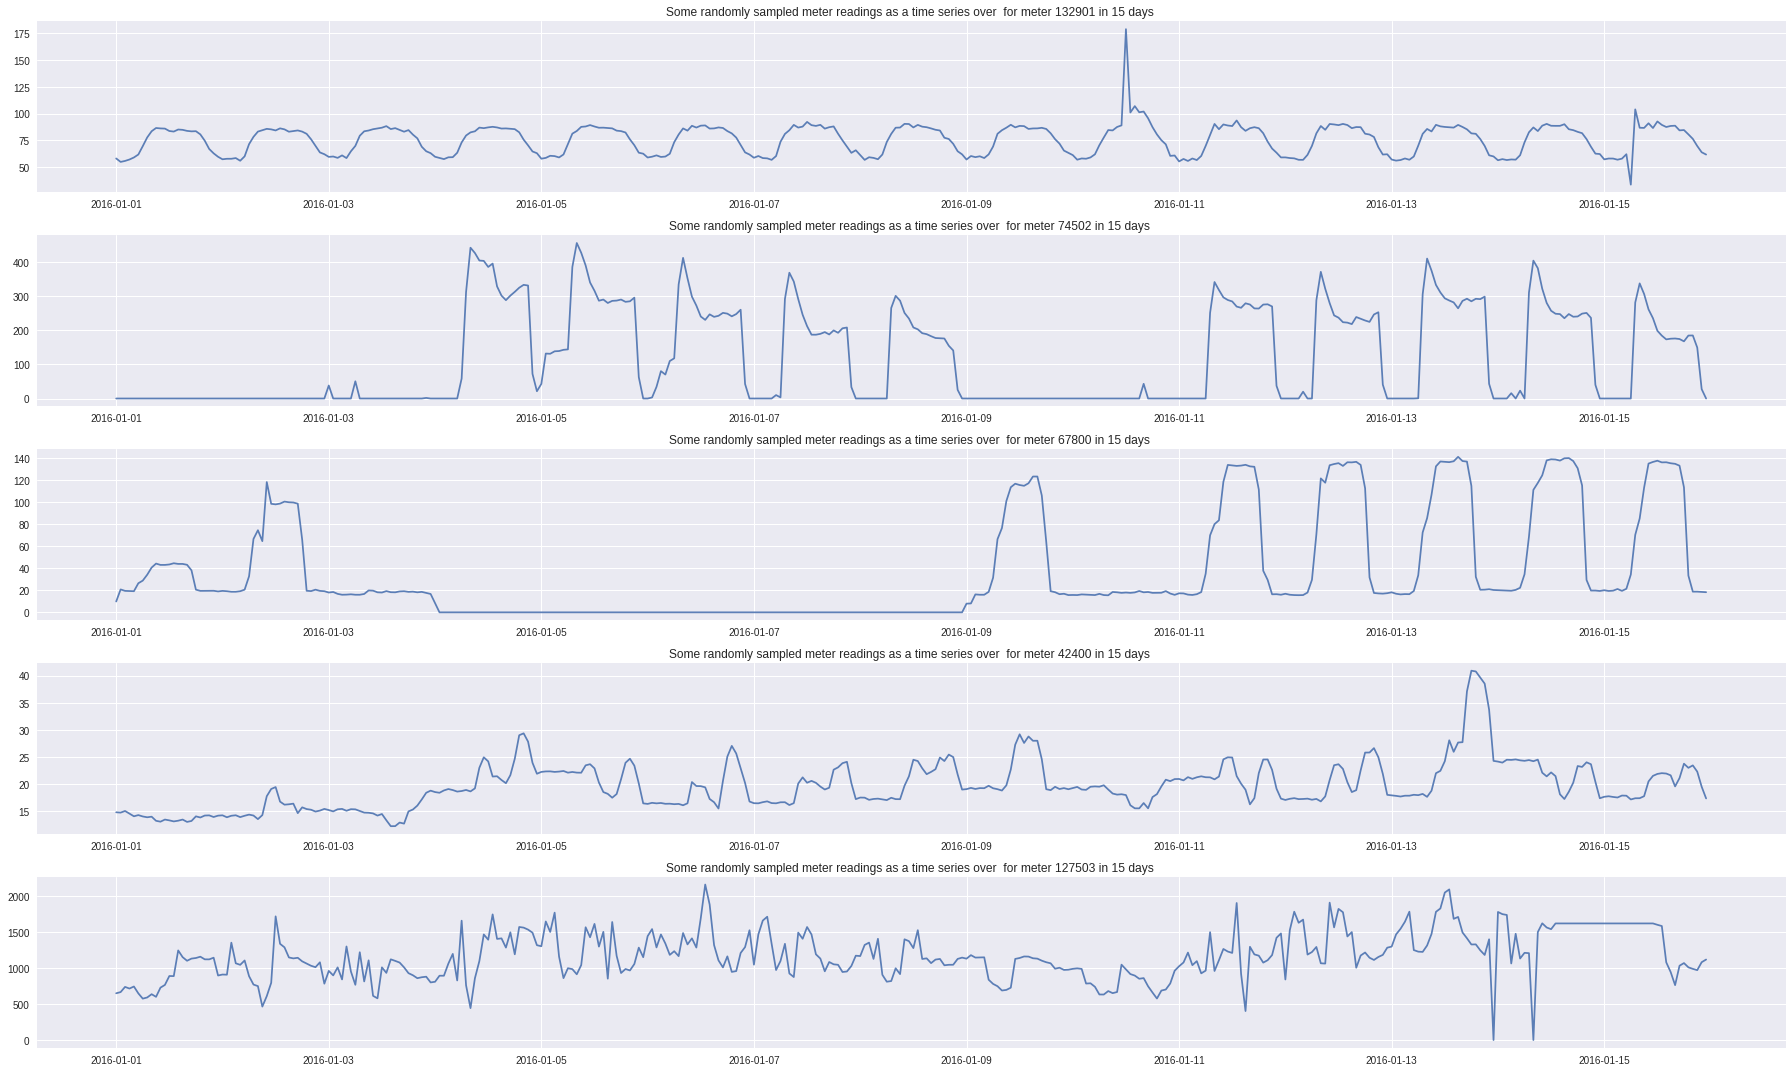

In [115]:
number_of_meter_reading = 5
days = 15
train_df['unique_meter'] = train_df['meter']+ train_df['building_id']*100


fig, axes = plt.subplots(number_of_meter_reading, 1, figsize = (5*number_of_meter_reading, 15))
fig.suptitle = ('Some randomly sampled meter readings as a time series over {days} days ')

unique_meters = list(train_df['unique_meter'].unique())

for i,j in enumerate(random.choices(unique_meters, k = number_of_meter_reading)):
    sample_data =  train_df[train_df['unique_meter'] == j]
    _x = sample_data['timestamp'][:24*days]
    _y = sample_data['meter_reading'][:24*days]
    axes[i].plot(_x,_y, alpha = 0.9)
    axes[i].set_title(f'Some randomly sampled meter readings as a time series over  for meter {j} in {days} days ')

plt.tight_layout()
plt.show()

In [116]:
# meter reading log scale 
train_df['meter_reading_log_scale'] = np.log1p(train_df['meter_reading'])

In [117]:
train_df

building_id  meter           timestamp  meter_reading  unique_meter  \
0                   0      0 2016-01-01 00:00:00          0.000             0   
1                   1      0 2016-01-01 00:00:00          0.000           100   
2                   2      0 2016-01-01 00:00:00          0.000           200   
3                   3      0 2016-01-01 00:00:00          0.000           300   
4                   4      0 2016-01-01 00:00:00          0.000           400   
...               ...    ...                 ...            ...           ...   
20216095         1444      0 2016-12-31 23:00:00          8.750        144400   
20216096         1445      0 2016-12-31 23:00:00          4.825        144500   
20216097         1446      0 2016-12-31 23:00:00          0.000        144600   
20216098         1447      0 2016-12-31 23:00:00        159.575        144700   
20216099         1448      0 2016-12-31 23:00:00          2.850        144800   

          meter_reading_log_scale  
0                        0.000000  
1                        0.000000  
2                        0.000000  
3                        0.000000  
4                        0.000000  
...                           ...  
20216095                 2.277267  
20216096                 1.762159  
20216097                 0.000000  
20216098                 5.078761  
20216099                 1.348073  

[20216100 rows x 6 columns]

total number of readings for meter type electricity          12060910
total number of readings for meter type electricity          11530741
total number of readings for meter type chilledwater          4182440
total number of readings for meter type chilledwater          3525936
total number of readings for meter type steam          2708713
total number of readings for meter type steam          2361753
total number of readings for meter type hotwater          1264037
total number of readings for meter type hotwater          923694


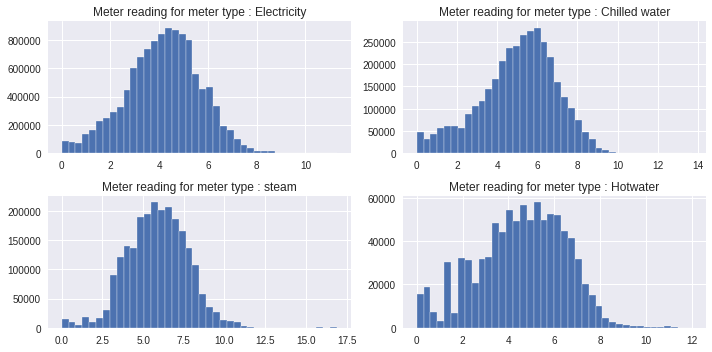

In [118]:
fig, axes = plt.subplots(2, 2, figsize = (10,5))


a =train_df['meter_reading_log_scale'][train_df['meter'] == 0]
nonzero = a[a != 0]
print(f"total number of readings for meter type electricity          {len(a)}")
print(f"total number of readings for meter type electricity          {len(nonzero)}")
axes[0,0].hist(nonzero, bins=40)
axes[0,0].set_title('Meter reading for meter type : Electricity')

a =train_df['meter_reading_log_scale'][train_df['meter'] == 1]
nonzero = a[a != 0]
print(f"total number of readings for meter type chilledwater          {len(a)}")
print(f"total number of readings for meter type chilledwater          {len(nonzero)}")
axes[0,1].hist(nonzero, bins=40)
axes[0,1].set_title('Meter reading for meter type : Chilled water')

a =train_df['meter_reading_log_scale'][train_df['meter'] == 2]
nonzero = a[a != 0]
print(f"total number of readings for meter type steam          {len(a)}")
print(f"total number of readings for meter type steam          {len(nonzero)}")
axes[1,0].hist(nonzero, bins=40)
axes[1,0].set_title('Meter reading for meter type : steam')

a =train_df['meter_reading_log_scale'][train_df['meter'] == 3]
nonzero = a[a != 0]
print(f"total number of readings for meter type hotwater          {len(a)}")
print(f"total number of readings for meter type hotwater          {len(nonzero)}")
axes[1,1].hist(nonzero, bins=40)
axes[1,1].set_title('Meter reading for meter type : Hotwater')

plt.tight_layout() # makes sure the titles and x-axes labels dont mess up
plt.show()

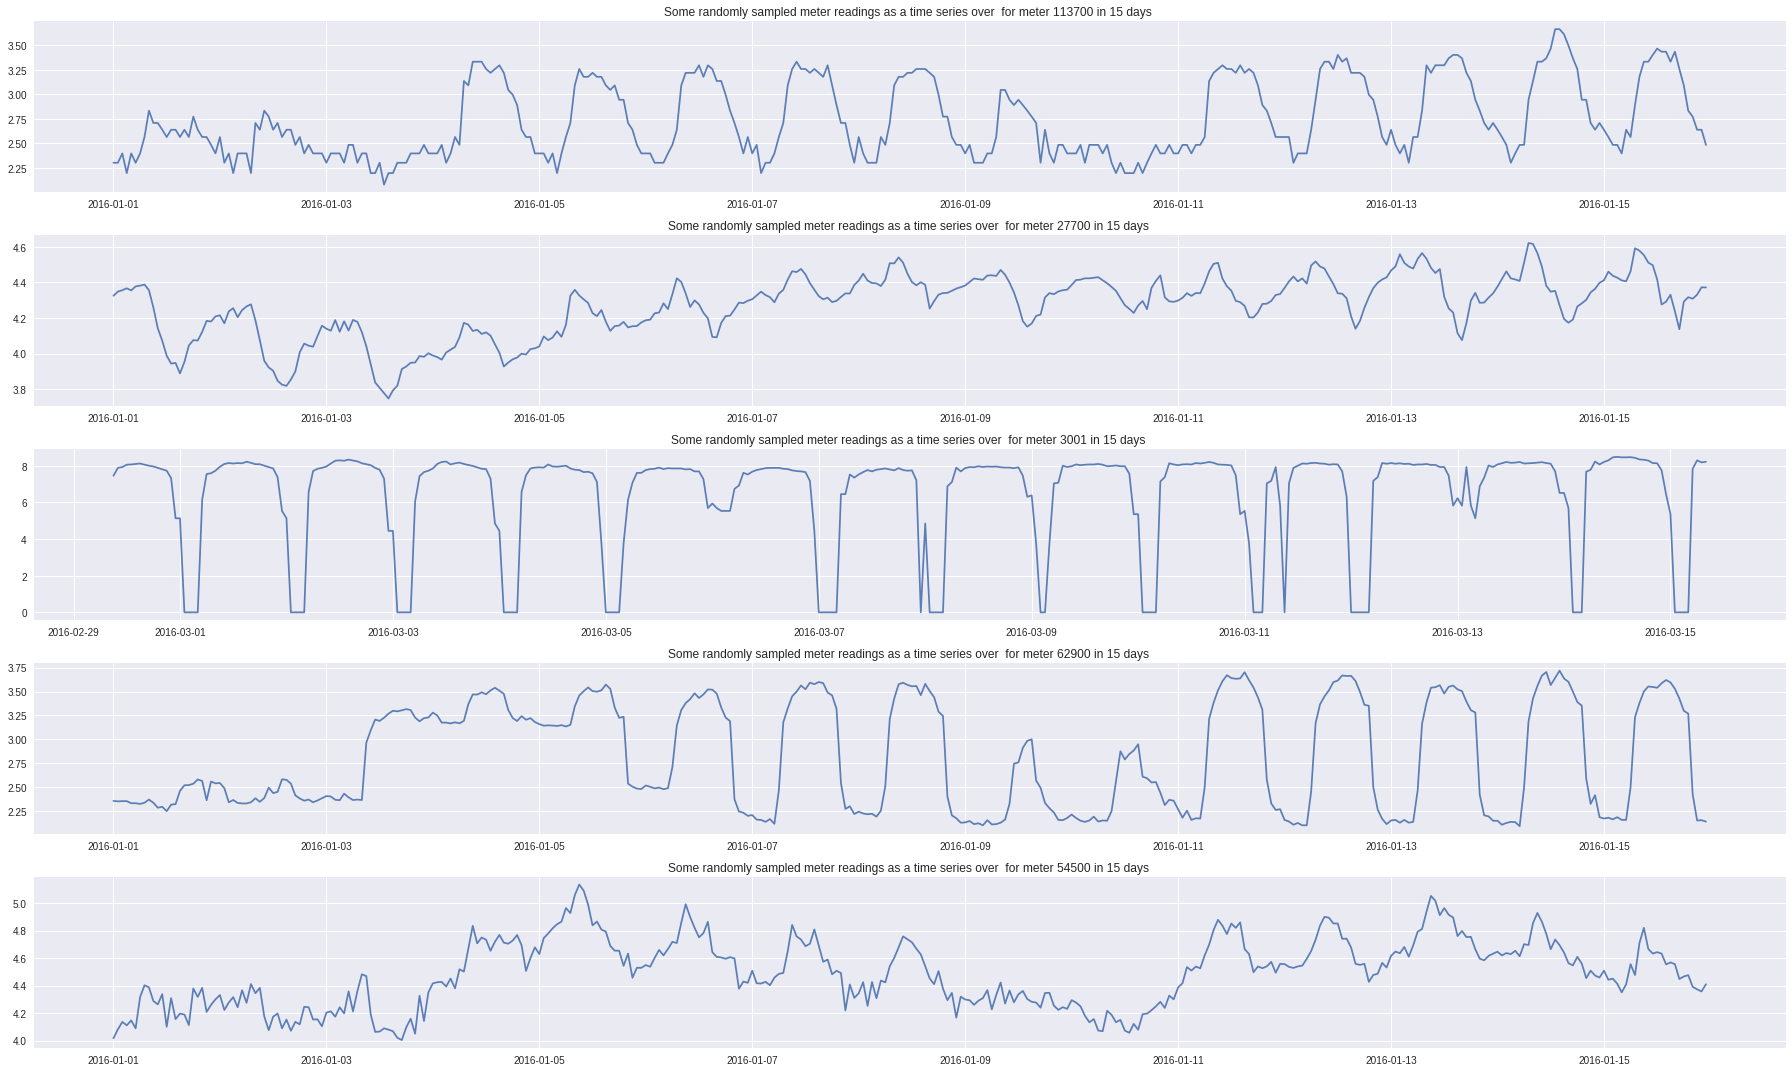

In [119]:
number_of_meter_reading = 5
days = 15
train_df['unique_meter'] = train_df['meter']+ train_df['building_id']*100


fig, axes = plt.subplots(number_of_meter_reading, 1, figsize = (5*number_of_meter_reading, 15))
fig.suptitle = ('Some randomly sampled meter readings as a time series over {days} days ')

unique_meters = list(train_df['unique_meter'].unique())

for i,j in enumerate(random.choices(unique_meters, k = number_of_meter_reading)):
    sample_data =  train_df[train_df['unique_meter'] == j]
    _x = sample_data['timestamp'][:24*days]
    _y = sample_data['meter_reading_log_scale'][:24*days]
    axes[i].plot(_x,_y, alpha = 0.9)
    axes[i].set_title(f'Some randomly sampled meter readings as a time series over  for meter {j} in {days} days ')

plt.tight_layout()
plt.show()

## test

In [134]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 GB


###  building ids

In [124]:
pd.Series(test_df['building_id'], dtype = "category").describe()

count     41697600
unique        1449
top           1258
freq         70080
Name: building_id, dtype: int64

In [125]:
print("Number of unique building_id in training set {}".format(pd.Series(test_df['building_id'], dtype = "category").describe()['unique']))

Number of unique building_id in training set 1449


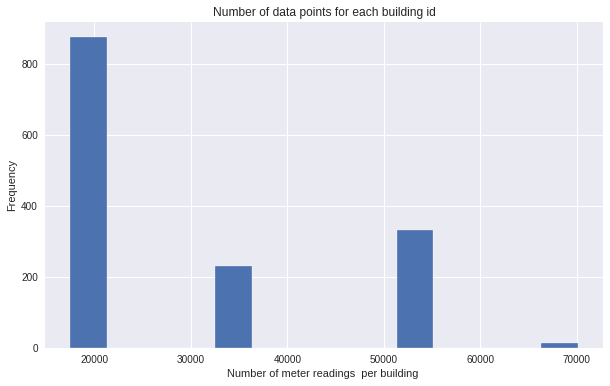

In [129]:
plt.figure(figsize = (10,6))
plt.hist(list(test_df['building_id'].value_counts()), bins = 14)
plt.title("Number of data points for each building id")
plt.xlabel("Number of meter readings  per building ")
plt.ylabel("Frequency")
plt.show()

more mter reading per building than the train data 

In [127]:
test_df['building_id'].value_counts().describe()

count     1449.000000
mean     28776.811594
std      15080.422384
min      17520.000000
25%      17520.000000
50%      17520.000000
75%      35040.000000
max      70080.000000
Name: building_id, dtype: float64

### Timestamps

In [147]:
timestamps = pd.to_datetime(test_df['timestamp'])
timestamps.describe()

count                41697600
unique                  17520
top       2018-08-14 12:00:00
freq                     2380
first     2017-01-01 00:00:00
last      2018-12-31 23:00:00
Name: timestamp, dtype: object

In [155]:
print(f"Number of unique timestamps is {timestamps.describe()['unique']}")
print(f"last  timestamp is {timestamps.describe()['last']}")
print(f"first timestamp is {timestamps.describe()['first']}")

Number of unique timestamps is 17520
last  timestamp is 2018-12-31 23:00:00
first timestamp is 2017-01-01 00:00:00


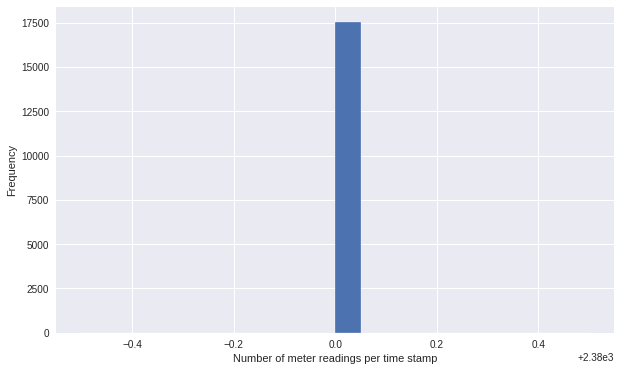

In [131]:
plt.figure(figsize = (10,6))
plt.hist(list(test_df['timestamp'].value_counts()), bins = 20)
plt.xlabel('Number of meter readings per time stamp')
plt.ylabel('Frequency')
plt.show()

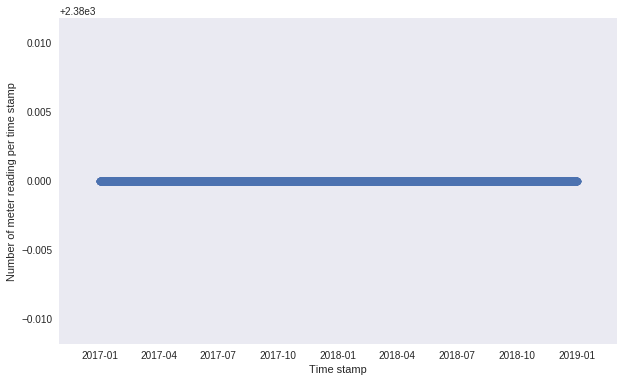

In [132]:
x = test_df['timestamp'].value_counts().index
y = test_df['timestamp'].value_counts()

plt.figure(figsize = (10,6))
plt.scatter(x,y)
plt.grid()
plt.xlabel('Time stamp')
plt.ylabel('Number of meter reading per time stamp')
plt.show()

### meter reading and meter id

In [158]:
test_df['meter'].value_counts()

0    24755760
1     8724960
2     5676480
3     2540400
Name: meter, dtype: int64

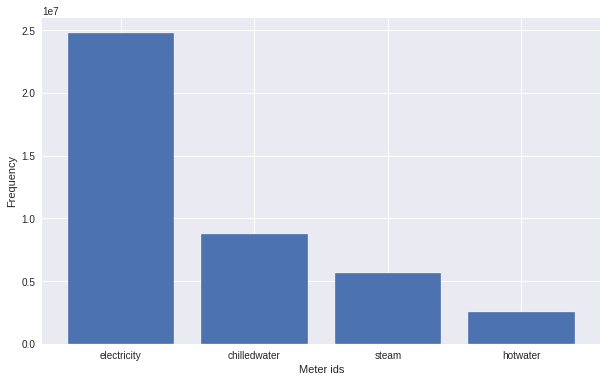

In [166]:
plt.figure(figsize= (10,6))
plt.bar(["electricity", "chilledwater", "steam", "hotwater"], test_df['meter'].value_counts())
plt.xlabel("Meter ids")
plt.ylabel('Frequency')
plt.show()

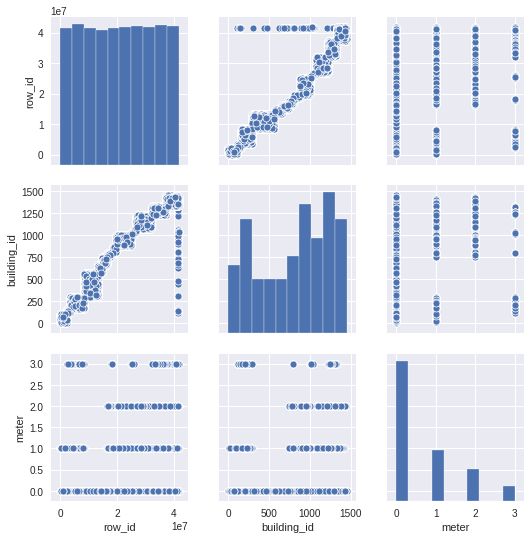

In [135]:
sns.pairplot(test_df.sample(100000, random_state = 0))

In [167]:
test_df.groupby(by = ['building_id', 'meter'])['building_id'].value_counts().describe()

count     2380.0
mean     17520.0
std          0.0
min      17520.0
25%      17520.0
50%      17520.0
75%      17520.0
max      17520.0
Name: building_id, dtype: float64

In [170]:
test_df['unique_meter'] = test_df['meter'] + test_df['building_id']*100

In [171]:
if np.array(train_df['unique_meter']).sort() == np.array(test_df['unique_meter']).sort():
    print('the same meters are present in train and test data')

the same meters are present in train and test data


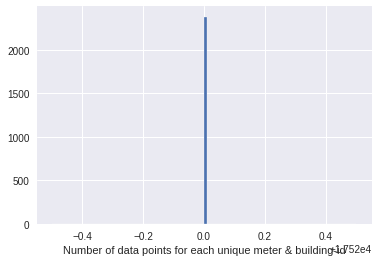

In [172]:
plt.figure(figsize = (6,4))
plt.hist(list(test_df.groupby(by = ['building_id', 'meter'])['meter'].value_counts()), bins = 100 )
plt.xlabel( ' Number of data points for each unique meter & building-id ')
plt.show()

##  building metadata 

In [173]:
building_df.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [179]:
len(building_df['building_id'])

1449

In [178]:
# missing data in year built and floor count
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [183]:
null_data = building_df.isnull()
for i in null_data.columns:
    print(f"coulumn name: {i}\t len:{len(null_data[i])} number of null values {np.sum(null_data[i])}")

coulumn name: site_id	 len:1449 number of null values 0
coulumn name: building_id	 len:1449 number of null values 0
coulumn name: primary_use	 len:1449 number of null values 0
coulumn name: square_feet	 len:1449 number of null values 0
coulumn name: year_built	 len:1449 number of null values 774
coulumn name: floor_count	 len:1449 number of null values 1094


In [191]:
if np.all(building_df['building_id'].value_counts().index.sort_values() == \
          train_df['building_id'].value_counts().index.sort_values()):
    print("building data and train data have same building_ids")
    

building data and train data have same building_ids


In [193]:
if np.all(building_df['building_id'].value_counts().index.sort_values() == \
          test_df['building_id'].value_counts().index.sort_values()):
    print("building data and test data have same building_ids")

building data and test data have same building_ids


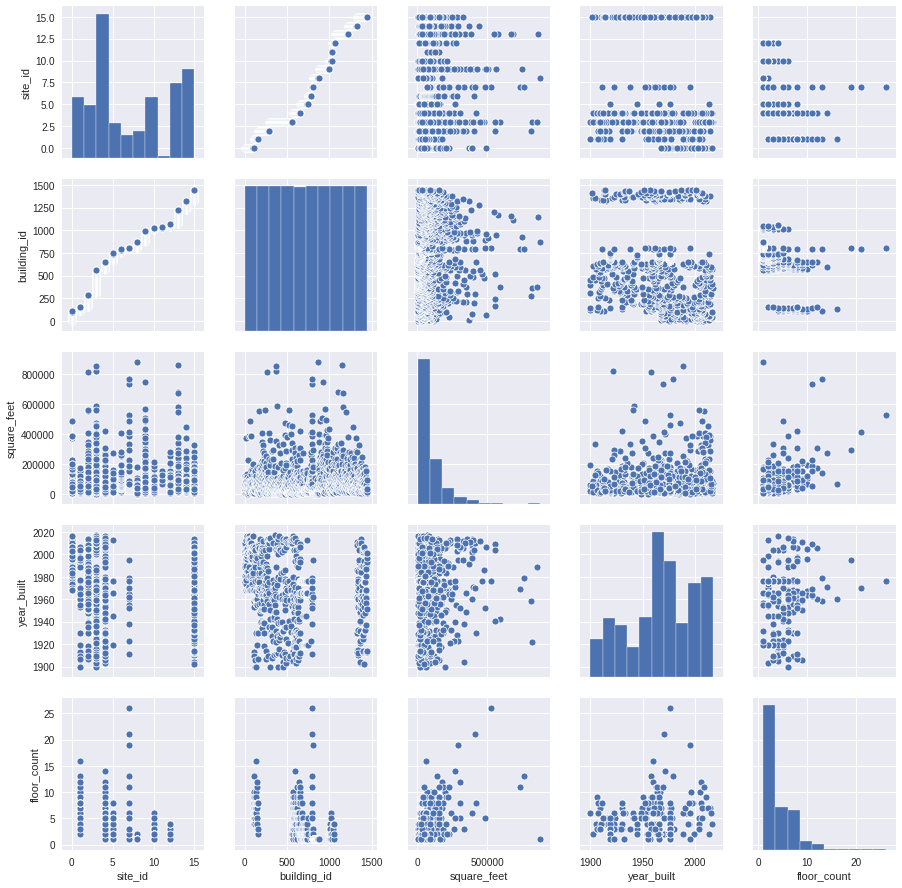

In [209]:
sns.pairplot(building_df)

### primary use

In [203]:
building_df['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

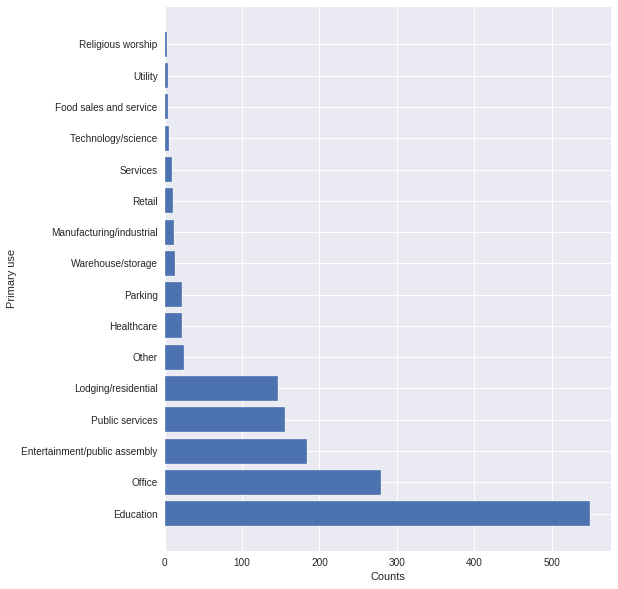

In [219]:
plt.figure(figsize = (8,10))
plt.barh(building_df['primary_use'].value_counts().index, building_df['primary_use'].value_counts())
plt.xlabel('Counts')
plt.ylabel('Primary use')
plt.show()

### square feet

In [221]:
building_df['square_feet'].describe()

count      1449.000000
mean      92111.776398
std      110769.950997
min         283.000000
25%       23012.000000
50%       57673.000000
75%      115676.000000
max      875000.000000
Name: square_feet, dtype: float64

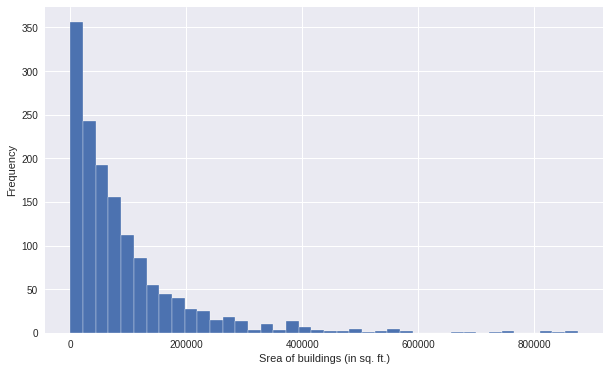

In [228]:
plt.figure(figsize = (10,6))
plt.hist(building_df['square_feet'], bins = 40)
plt.xlabel('Area of buildings (in sq. ft.)')
plt.ylabel('Frequency')
plt.show()

### year built 

In [230]:
building_df['year_built'].describe()

count     675.000000
mean     1967.957037
std        31.054030
min      1900.000000
25%      1949.000000
50%      1970.000000
75%      1995.000000
max      2017.000000
Name: year_built, dtype: float64

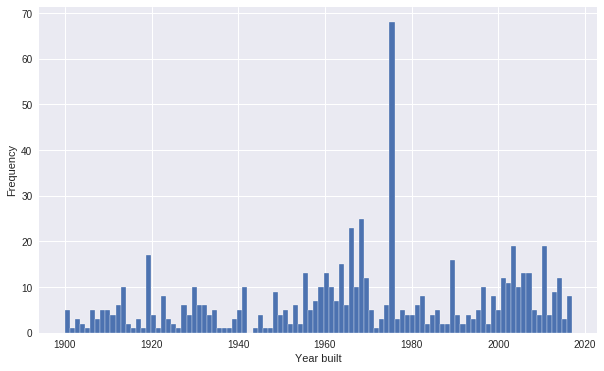

In [234]:
plt.figure(figsize = (10,6))
plt.hist(building_df['year_built'], bins = 100)
plt.xlabel('Year built')
plt.ylabel('Frequency')
plt.show()

In [258]:
building_df['year_built'][ ~building_df['year_built'].isnull()]

0       2008.0
1       2004.0
2       1991.0
3       2002.0
4       1975.0
         ...  
1443    1913.0
1444    1914.0
1446    1997.0
1447    2001.0
1448    2001.0
Name: year_built, Length: 675, dtype: float64

### floor count

In [235]:
building_df['floor_count'].describe()

count    355.000000
mean       3.740845
std        3.333683
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       26.000000
Name: floor_count, dtype: float64

In [244]:
nonnull = building_df['floor_count'][ ~building_df['floor_count'].isnull()] # invert 

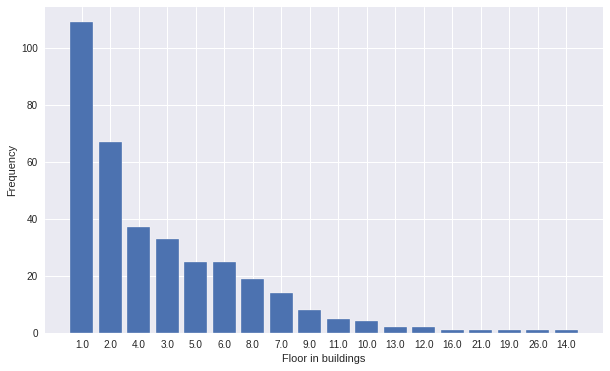

In [252]:
nonnull = building_df['floor_count'][ ~building_df['floor_count'].isnull()] # invert 
plt.figure(figsize = (10,6))
plt.bar(building_df['floor_count'][ ~building_df['floor_count'].isnull()].apply(str).value_counts().index,building_df['floor_count'][ ~building_df['floor_count'].isnull()].value_counts() )
plt.xlabel('Floor in buildings')
plt.ylabel('Frequency')
plt.show()

## Weather train data

In [261]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_train_df.describe()

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  139773.000000    139718.000000    70600.000000    139660.000000   
mean        7.478977        14.418106        2.149306         7.350158   
std         4.604744        10.626595        2.599150         9.790235   
min         0.000000       -28.900000        0.000000       -35.000000   
25%         3.000000         7.200000        0.000000         0.600000   
50%         7.000000        15.000000        2.000000         8.300000   
75%        11.000000        22.200000        4.000000        14.400000   
max        15.000000        47.200000        9.000000        26.100000   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count       89484.000000       129155.000000   133505.000000  139469.000000  
mean            0.983047         1016.158038      180.526632       3.560527  
std             8.463678            7.629684      111.523629       2.335874  
min            -1.000000          968.200000        0.000000       0.000000  
25%             0.000000         1011.800000       80.000000       2.100000  
50%             0.000000         1016.400000      190.000000       3.100000  
75%             0.000000         1020.800000      280.000000       5.000000  
max           343.000000         1045.500000      360.000000      19.000000

In [262]:
weather_train_df.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2016-01-01 00:00:00             25.0             6.0   
1        0 2016-01-01 01:00:00             24.4             NaN   
2        0 2016-01-01 02:00:00             22.8             2.0   
3        0 2016-01-01 03:00:00             21.1             2.0   
4        0 2016-01-01 04:00:00             20.0             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.7             0.0   
1             21.1               -1.0              1020.2            70.0   
2             21.1                0.0              1020.2             0.0   
3             20.6                0.0              1020.1             0.0   
4             20.0               -1.0              1020.0           250.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0  
3         0.0  
4         2.6

In [263]:
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
weather_test_df.describe()

site_id  air_temperature  cloud_coverage  dew_temperature  \
count  277243.000000    277139.000000   136795.000000    276916.000000   
mean        7.484654        14.276863        2.187317         7.487658   
std         4.616959        10.741605        2.620627        10.153973   
min         0.000000       -28.100000        0.000000       -31.600000   
25%         3.000000         7.200000        0.000000         0.600000   
50%         7.000000        15.000000        2.000000         8.400000   
75%        12.000000        22.200000        4.000000        15.000000   
max        15.000000        48.300000        9.000000        26.700000   

       precip_depth_1_hr  sea_level_pressure  wind_direction     wind_speed  
count      181655.000000       255978.000000   264873.000000  276783.000000  
mean            1.095395         1016.195762      180.426023       3.548873  
std             9.163511            7.940392      110.456872       2.317184  
min            -1.000000          972.000000        0.000000       0.000000  
25%             0.000000         1011.600000       80.000000       2.100000  
50%             0.000000         1016.300000      190.000000       3.100000  
75%             0.000000         1020.800000      280.000000       4.600000  
max           597.000000         1050.100000      360.000000      24.200000

In [265]:
weather_test_df.head()

site_id           timestamp  air_temperature  cloud_coverage  \
0        0 2017-01-01 00:00:00             17.8             4.0   
1        0 2017-01-01 01:00:00             17.8             2.0   
2        0 2017-01-01 02:00:00             16.1             0.0   
3        0 2017-01-01 03:00:00             17.2             0.0   
4        0 2017-01-01 04:00:00             16.7             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             11.7                NaN              1021.4           100.0   
1             12.8                0.0              1022.0           130.0   
2             12.8                0.0              1021.9           140.0   
3             13.3                0.0              1022.2           140.0   
4             13.3                0.0              1022.3           130.0   

   wind_speed  
0         3.6  
1         3.1  
2         3.1  
3         3.1  
4         2.6

In [273]:
null_data = weather_train_df.isnull()
print("weather train")
print("")
for i in null_data.columns:
    print(f"coulumn name:{i: <{20}}len:{len(null_data[i])} \t number of null values {np.sum(null_data[i])}")

print("-"*80)
null_data = weather_test_df.isnull()
print("weather test")
print("")
for i in null_data.columns:
    print(f"coulumn name:{i: <{20}}len:{len(null_data[i])} \t number of null values {np.sum(null_data[i])}")

weather train

coulumn name:site_id             len:139773 	 number of null values 0
coulumn name:timestamp           len:139773 	 number of null values 0
coulumn name:air_temperature     len:139773 	 number of null values 55
coulumn name:cloud_coverage      len:139773 	 number of null values 69173
coulumn name:dew_temperature     len:139773 	 number of null values 113
coulumn name:precip_depth_1_hr   len:139773 	 number of null values 50289
coulumn name:sea_level_pressure  len:139773 	 number of null values 10618
coulumn name:wind_direction      len:139773 	 number of null values 6268
coulumn name:wind_speed          len:139773 	 number of null values 304
--------------------------------------------------------------------------------
weather test

coulumn name:site_id             len:277243 	 number of null values 0
coulumn name:timestamp           len:277243 	 number of null values 0
coulumn name:air_temperature     len:277243 	 number of null values 104
coulumn name:cloud_coverage 

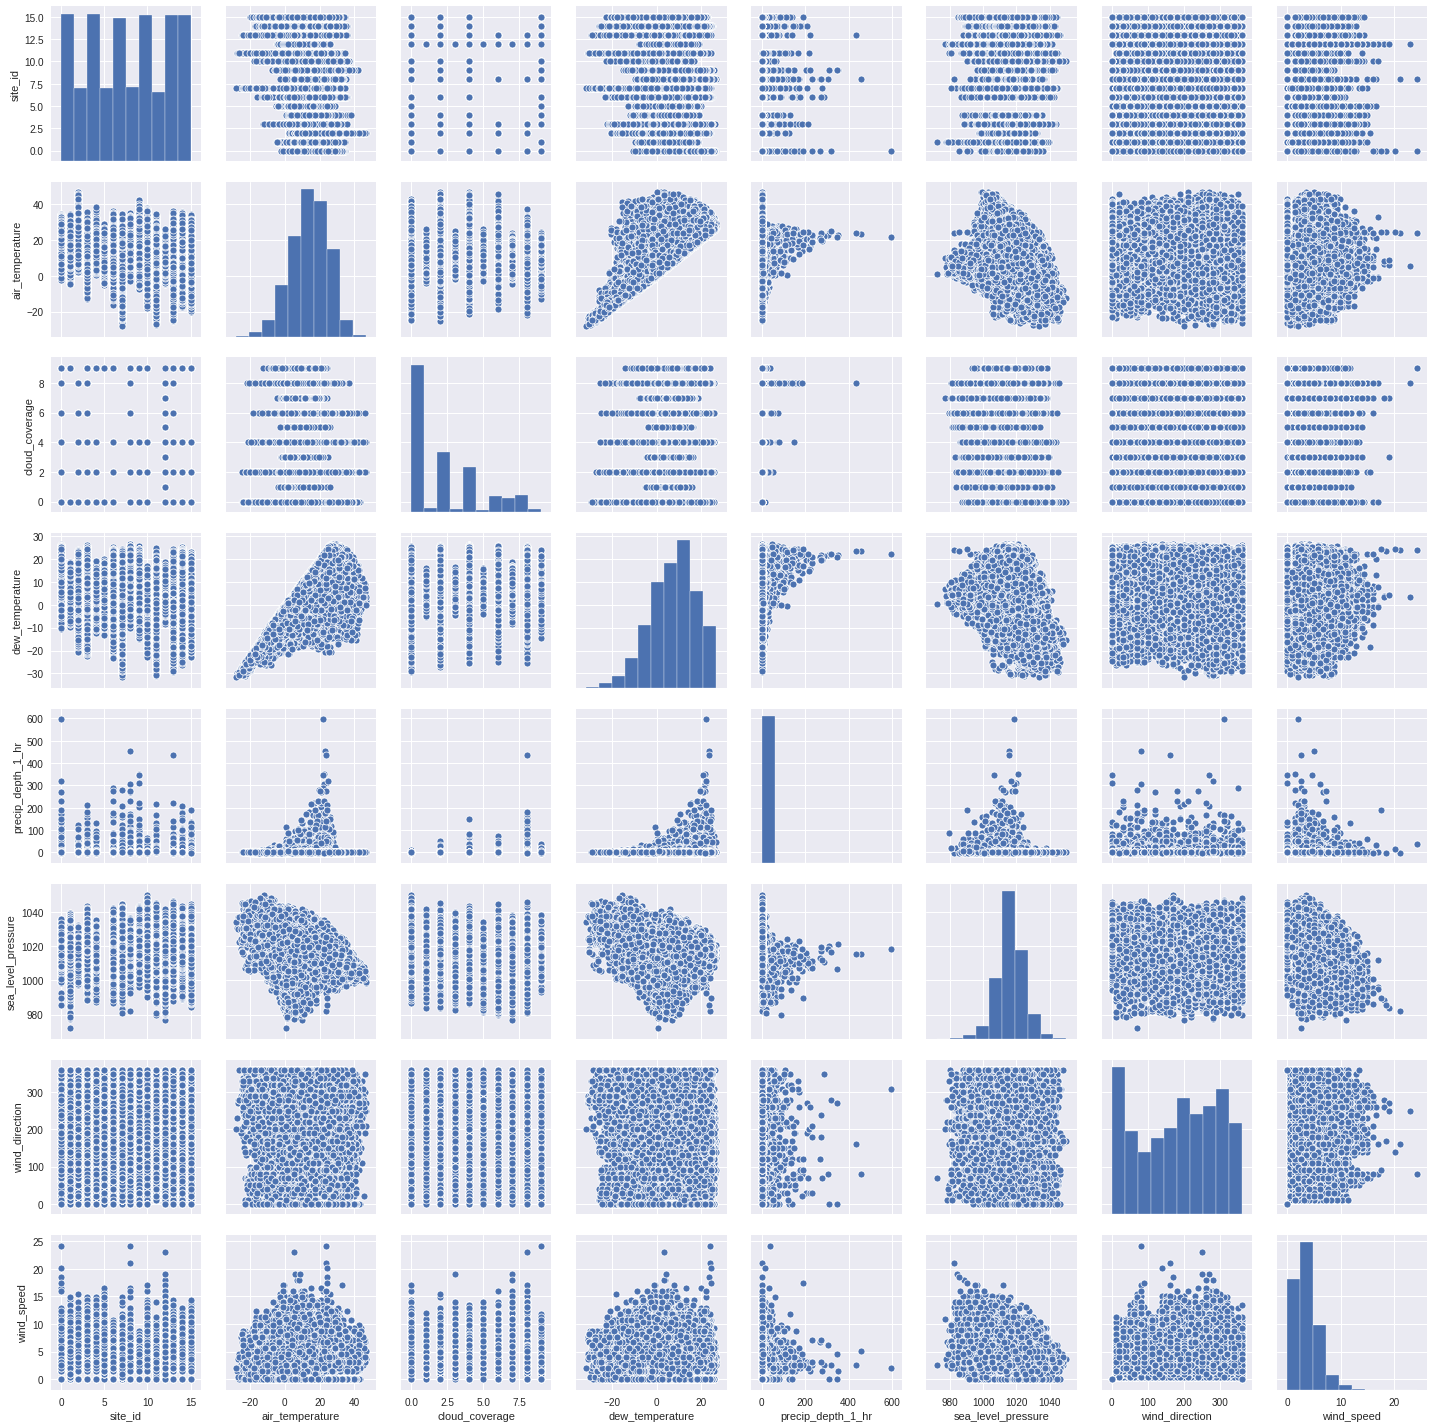

In [275]:
sns.pairplot(weather_test_df.sample(100000, random_state = 0))

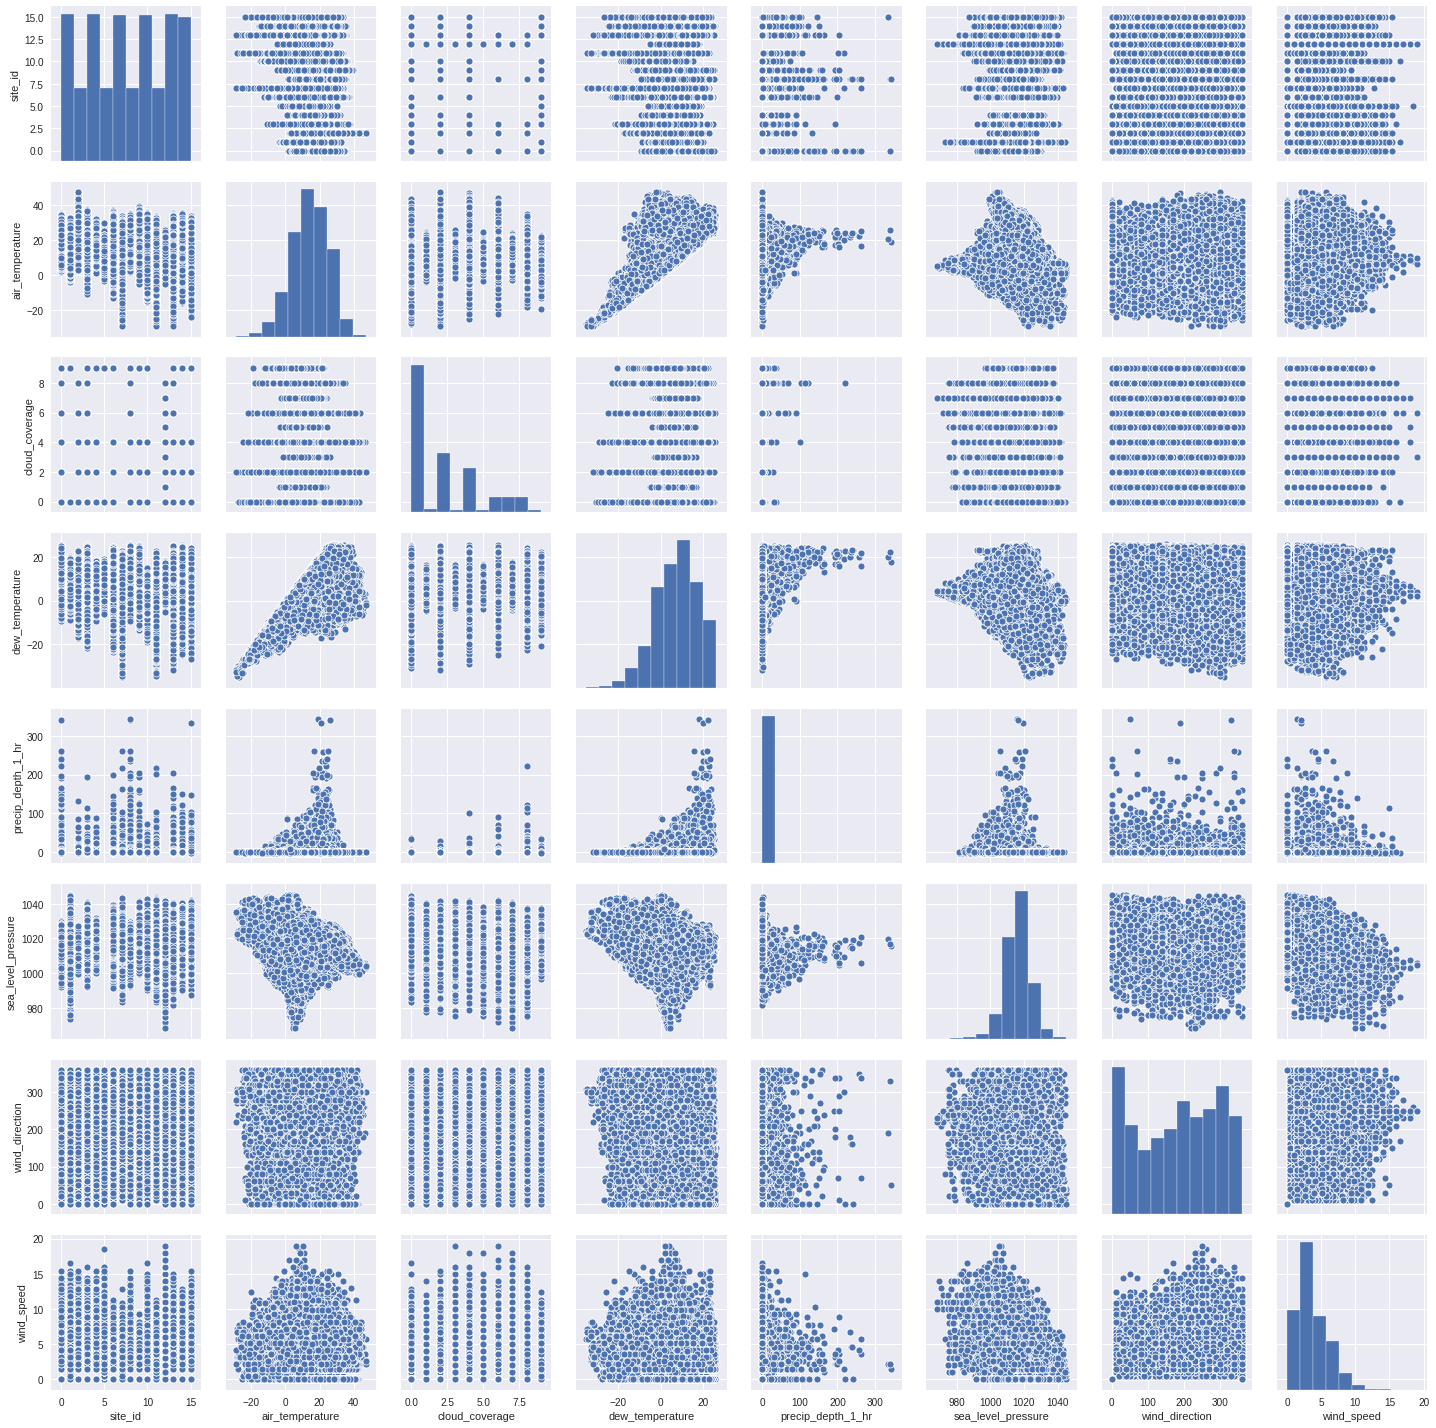

In [276]:
sns.pairplot(weather_train_df.sample(100000, random_state = 0))

In [297]:
len(weather_train_df['site_id'].value_counts()) -1

15

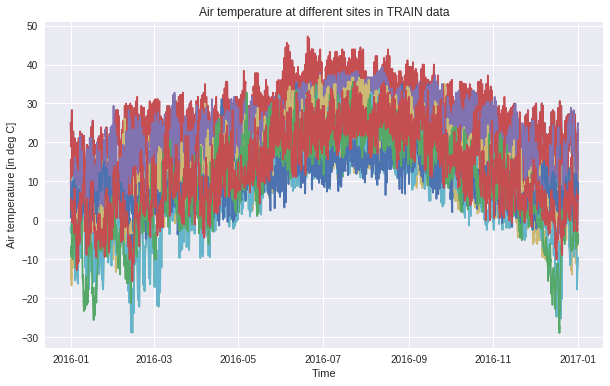

In [309]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['air_temperature'])
plt.xlabel('Time')
plt.ylabel('Air temperature [in deg C]')
plt.title('Air temperature at different sites in TRAIN data')
plt.show()
    

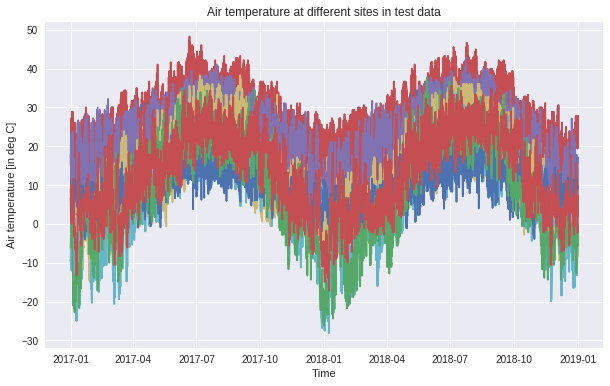

In [307]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['air_temperature'])
plt.xlabel('Time')
plt.ylabel('Air temperature [in deg C]')

plt.title('Air temperature at different sites in test data')

plt.show()

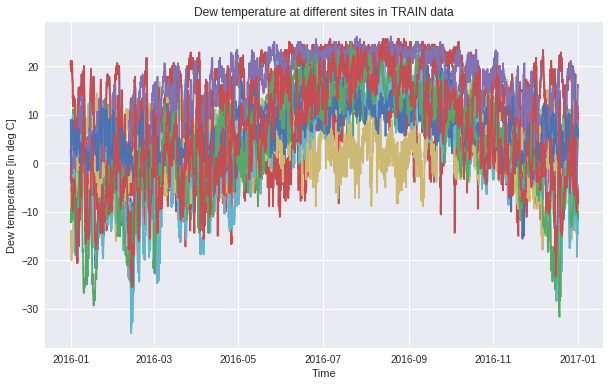

In [310]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['dew_temperature'])
plt.xlabel('Time')
plt.ylabel('Dew temperature [in deg C]')
plt.title('Dew temperature at different sites in TRAIN data')
plt.show()

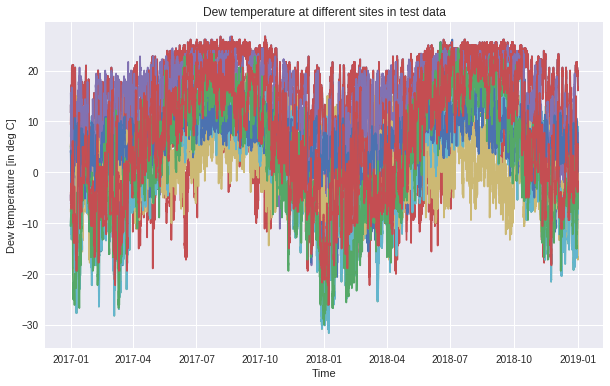

In [311]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['dew_temperature'])
plt.xlabel('Time')
plt.ylabel('Dew temperature [in deg C]')

plt.title('Dew temperature at different sites in test data')

plt.show()

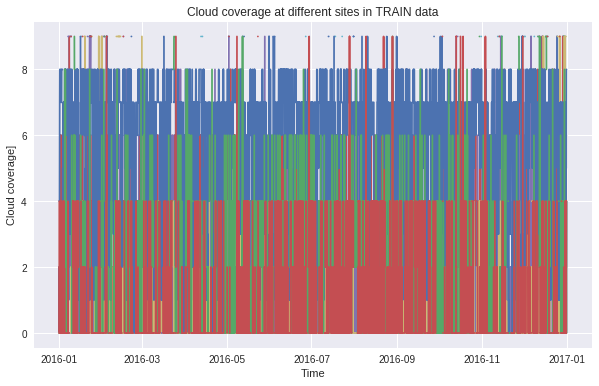

In [312]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['cloud_coverage'])
plt.xlabel('Time')
plt.ylabel('Cloud coverage]')
plt.title('Cloud coverage at different sites in TRAIN data')
plt.show()

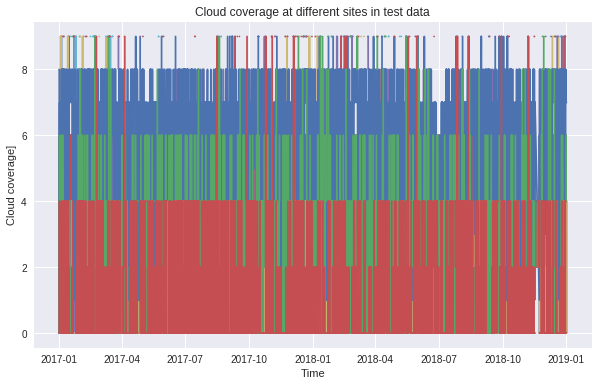

In [313]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['cloud_coverage'])
plt.xlabel('Time')
plt.ylabel('Cloud coverage]')
plt.title('Cloud coverage at different sites in test data')
plt.show()

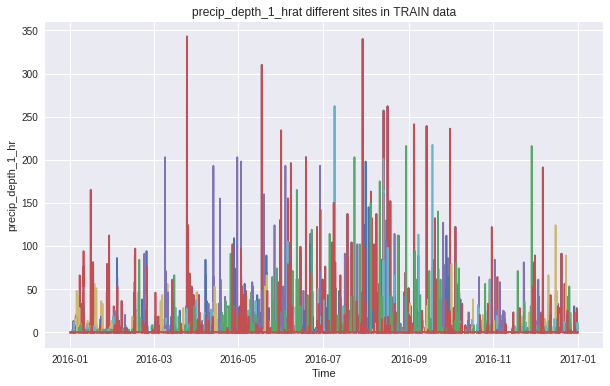

In [314]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['precip_depth_1_hr'])
plt.xlabel('Time')
plt.ylabel('precip_depth_1_hr')
plt.title('precip_depth_1_hrat different sites in TRAIN data')
plt.show()

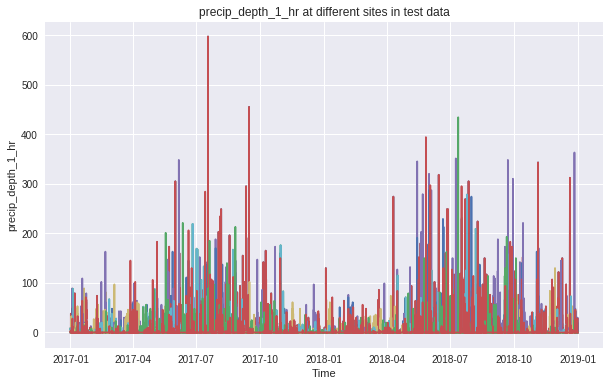

In [315]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['precip_depth_1_hr'])
plt.xlabel('Time')
plt.ylabel('precip_depth_1_hr')
plt.title('precip_depth_1_hr at different sites in test data')
plt.show()

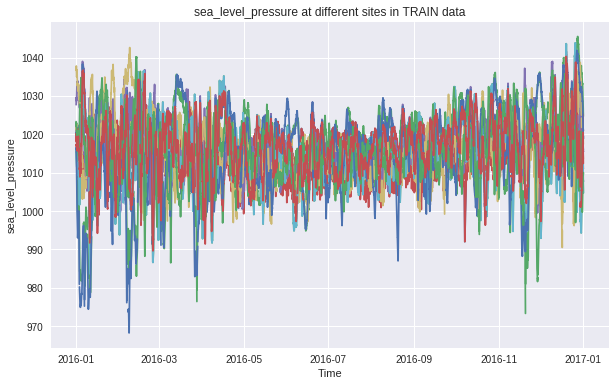

In [316]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['sea_level_pressure'])
plt.xlabel('Time')
plt.ylabel('sea_level_pressure')
plt.title('sea_level_pressure at different sites in TRAIN data')
plt.show()

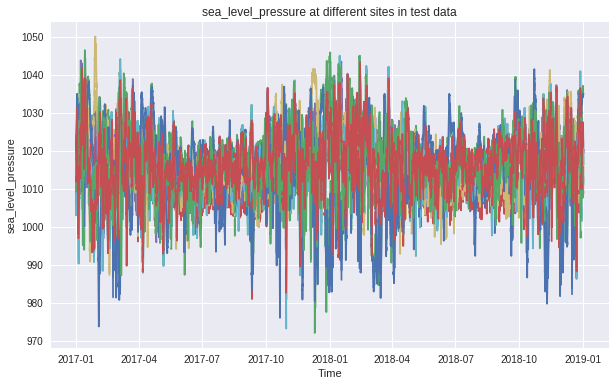

In [317]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['sea_level_pressure'])
plt.xlabel('Time')
plt.ylabel('sea_level_pressure')
plt.title('sea_level_pressure at different sites in test data')
plt.show()

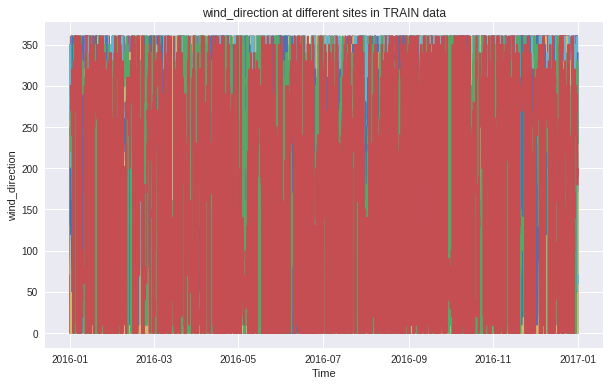

In [319]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['wind_direction'])
plt.xlabel('Time')
plt.ylabel('wind_direction')
plt.title('wind_direction at different sites in TRAIN data')
plt.show()

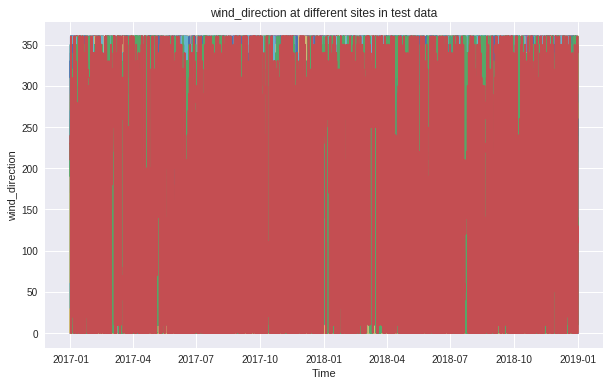

In [320]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['wind_direction'])
plt.xlabel('Time')
plt.ylabel('wind_direction')
plt.title('wind_direction at different sites in test data')
plt.show()

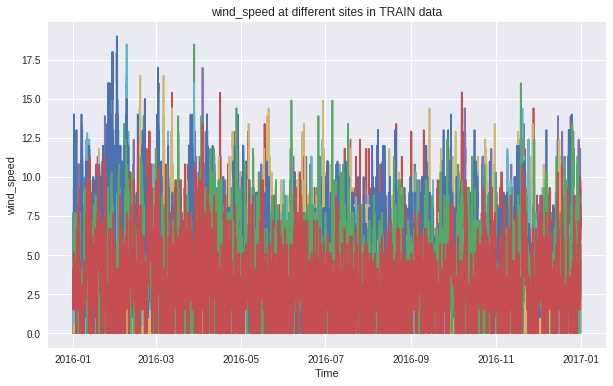

In [318]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_train_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_train_df[weather_train_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['wind_speed'])
plt.xlabel('Time')
plt.ylabel('wind_speed')
plt.title('wind_speed at different sites in TRAIN data')
plt.show()

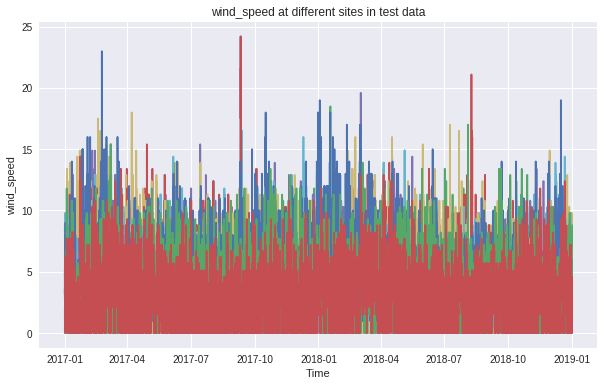

In [321]:
plt.figure(figsize = (10,6))
possible_sites = len(weather_test_df['site_id'].value_counts()) -1
for i in range(possible_sites):
    data = weather_test_df[weather_test_df['site_id'] == i ]
    plt.plot(data['timestamp'], data['wind_speed'])
plt.xlabel('Time')
plt.ylabel('wind_speed')
plt.title('wind_speed at different sites in test data')
plt.show()

In [ ]:
# Get names of columns with missing values 
cols_with_missing = [col for col in train_df.columns if train_df]

In [25]:
# there's plenty of missing data and if you want to drop it the way out is 
building_df_drop_missing = building_df.dropna(axis = 0)
train_df_drop_missing = train_df.dropna(axis = 0)
weather_train_df_drop_missing = weather_train_df.dropna(axis = 0)

In [26]:
building_df_drop_missing.describe()

site_id  building_id    square_feet   year_built  floor_count
count  231.000000   231.000000     231.000000   231.000000   231.000000
mean     4.043290   572.480519   87130.112554          inf     4.726562
std      1.579168   210.696213  106814.214089    28.234375     3.591797
min      1.000000   107.000000     387.000000  1900.000000     1.000000
25%      4.000000   582.500000   22407.500000  1932.500000     2.000000
50%      4.000000   641.000000   56343.000000  1966.000000     4.000000
75%      5.000000   700.500000  116967.500000  1976.000000     6.500000
max      7.000000   803.000000  764237.000000  2016.000000    26.000000

In [27]:
train_df_drop_missing.describe()

building_id         meter  meter_reading
count  2.021610e+07  2.021610e+07   2.021610e+07
mean   7.992780e+02  6.624412e-01   1.988706e+03
std    4.269133e+02  9.309921e-01   1.532159e+05
min    0.000000e+00  0.000000e+00   0.000000e+00
25%    3.930000e+02  0.000000e+00   1.830000e+01
50%    8.950000e+02  0.000000e+00   7.877500e+01
75%    1.179000e+03  1.000000e+00   2.679840e+02
max    1.448000e+03  3.000000e+00   2.190470e+07

In [6]:
# Merge train_df, building_df and weather_train_df  into train 
# Merge test_df, building_df and test_df  into test

# first merge train/test_df with building_df use 

# used how = 'left' option to Keep every row in the left dataframe
# Where there are missing values of the “on” variable in the right dataframe, 
# add empty / NaN values in the result.
train_df = train_df.merge(building_df, how = 'left', on = 'building_id')
test_df = test_df.merge(building_df, how = 'left', on = 'building_id')

In [7]:
# now merge train/test_df with weather_train_df/weather_test_df using site_id [unique]
# and timestamp [making dataset by the day]
train_df = train_df.merge(weather_train_df, how= 'left', on = ['site_id', 'timestamp'])
test_df = test_df.merge(weather_test_df, how = 'left', on = ['site_id', 'timestamp'])

In [8]:
train_df.to_hdf(os.path.join(input_dir,"merged_train_df.hdf"), key = 'df', mode ='w')

In [9]:
# save merged data to input_dir 
test_df.to_hdf(os.path.join(input_dir,"merged_test_df.hdf"), key = 'df', mode = 'w')

In [14]:
del weather_test_df, weather_train_df, building_df
gc.collect()

11545